#**Librerías**

#**Contextualización**
En la empresa de seguridad SecurityTech y vigilancia se busca innovar en sus sistemas de seguridad un modelo de detección de rostros faciales que permita identificar la persona y genere una registro de la persona identificada, este modelo va a ser entrenado mediante el dataset Labeless Faces in the Wild(LFW) el cual normalizaremos para ser usado bajo escala de grises.



# **Pruebas con algoritmos de ML**

*   Gaussian Naive Bayes
*   Decision Tree
*   Random Forest
*   Support Vector Machine

##01_Importación y separación de datos para su manejo

In [7]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [77]:
import numpy as np
from sklearn.datasets import fetch_lfw_people

# -----------------------------
# 1. Cargar el dataset original
# -----------------------------
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

X = lfw_people.data
y = lfw_people.target
images = lfw_people.images
target_names = lfw_people.target_names

print(f"Total de imágenes: {X.shape[0]}")
print(f"Tamaño de cada imagen: {images.shape[1]}x{images.shape[2]}")
print(f"Número de personas (clases): {len(target_names)}")


# --------------------------------------------------
# 2. Encontrar el índice de la persona "George W Bush"
# --------------------------------------------------
bush_index = np.where(target_names == "George W Bush")[0][0]

# Queremos mantener SOLO 100 imágenes de Bush
keep = 100


# -------------------------------------
# 3. Separar imágenes de Bush y de otros
# -------------------------------------
mask_other = y != bush_index                   # True = NO es Bush
indices_other = np.where(mask_other)[0]        # índices de otras personas
indices_bush = np.where(y == bush_index)[0]    # índices de Bush

# Mezclar aleatoriamente las imágenes de Bush
np.random.shuffle(indices_bush)

# Seleccionar SOLO 100 imágenes de Bush
indices_bush_keep = indices_bush[:keep]


# ------------------------------------------------
# 4. Unir índices: (todos los otros + 100 de Bush)
# ------------------------------------------------
final_indices = np.concatenate([indices_other, indices_bush_keep])

# Ordenarlos para mantener consistencia
final_indices = np.sort(final_indices)


# ------------------------------------------
# 5. Filtrar el dataset usando final_indices
# ------------------------------------------
X_filtered = X[final_indices]
y_filtered = y[final_indices]
images_filtered = images[final_indices]


# --------------------------------------------------
# 6. Remapear las etiquetas para que queden consecutivas
# --------------------------------------------------
unique_classes = np.unique(y_filtered)

# Diccionario: old_label → new_label
new_label_map = {old: new for new, old in enumerate(unique_classes)}

# Crear vector de etiquetas remapeadas
y_filtered = np.array([new_label_map[label] for label in y_filtered])

# Filtrar también los nombres de las personas
target_names_filtered = target_names[unique_classes]

# ---------------------
# 7. Mostrar resultados
# ---------------------
print("\n--- Dataset después del filtrado ---")
print(f"Total de imágenes: {X_filtered.shape[0]}")
print(f"Número de clases (personas): {len(target_names_filtered)}")

# Contar imágenes por persona
print("\nImágenes por persona:")
unique, counts = np.unique(y_filtered, return_counts=True)
for name, count in zip(target_names_filtered, counts):
    print(f"{name}: {count}")


Total de imágenes: 1288
Tamaño de cada imagen: 50x37
Número de personas (clases): 7

--- Dataset después del filtrado ---
Total de imágenes: 858
Número de clases (personas): 7

Imágenes por persona:
Ariel Sharon: 77
Colin Powell: 236
Donald Rumsfeld: 121
George W Bush: 100
Gerhard Schroeder: 109
Hugo Chavez: 71
Tony Blair: 144


##02_Visualizar imágenes

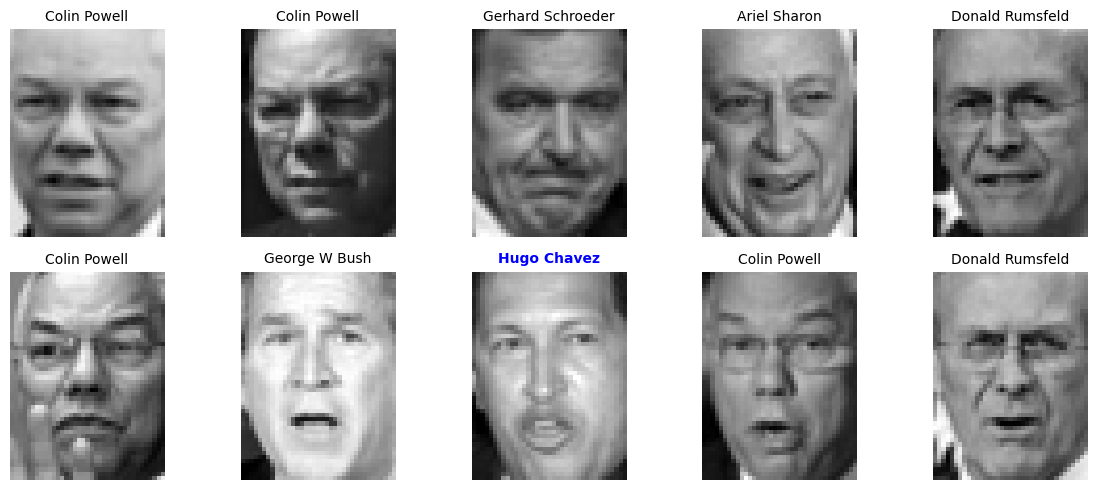

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------------
# Configuración
# -------------------------------------------------------------------
# 1. Identificar cuál es la etiqueta de TU clase (asumimos que es la última agregada)
# Si usaste el código anterior, tus fotos están al final, así que tomamos la etiqueta del último elemento
mi_etiqueta = y_filtered[-1]

# 2. Separar los índices: Los tuyos vs. El resto del mundo
indices_mios = np.where(y_filtered == mi_etiqueta)[0]
indices_otros = np.where(y_filtered != mi_etiqueta)[0]

# -------------------------------------------------------------------
# Selección de imágenes para el Grid
# -------------------------------------------------------------------
# Elegimos 1 foto tuya al azar
idx_mio_seleccionado = np.random.choice(indices_mios, 1, replace=False)

# Elegimos 9 fotos de los otros al azar
idx_otros_seleccionados = np.random.choice(indices_otros, 9, replace=False)

# Concatenamos los índices (1 tuyo + 9 otros)
indices_visualizar = np.concatenate([idx_otros_seleccionados, idx_mio_seleccionado])

# ¡IMPORTANTE! Mezclamos (shuffle) para que tu foto no salga siempre al final,
# sino "escondida" entre las demás como en el dataset real.
np.random.shuffle(indices_visualizar)

# -------------------------------------------------------------------
# Graficar (Estilo idéntico a tu ejemplo)
# -------------------------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(12, 5)) # 2 filas, 5 columnas

for i, ax in enumerate(axes.flat):
    # Obtenemos el índice real para esta posición del grid
    idx_real = indices_visualizar[i]

    # Mostramos la imagen
    ax.imshow(images_filtered[idx_real], cmap="gray")

    # Obtenemos el nombre correspondiente
    etiqueta_num = y_filtered[idx_real]
    nombre = target_names_filtered[etiqueta_num]

    # Ponemos el título
    # Truco visual: Si es tu foto, ponemos el título en azul negrita para que la ubiques rápido,
    # el resto en negro normal como en la imagen original.
    if etiqueta_num == mi_etiqueta:
        ax.set_title(nombre, fontsize=10, color='blue', fontweight='bold')
    else:
        ax.set_title(nombre, fontsize=10, color='black')

    ax.axis("off")

plt.tight_layout()
plt.show()

##03_Normalización de datos para la escala de grises

In [79]:
X_filtered = X_filtered / 255.0

##04_Dividir en entrenamiento y prueba

In [80]:
from sklearn.model_selection import train_test_split

X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.25, random_state=42, stratify=y_filtered
)


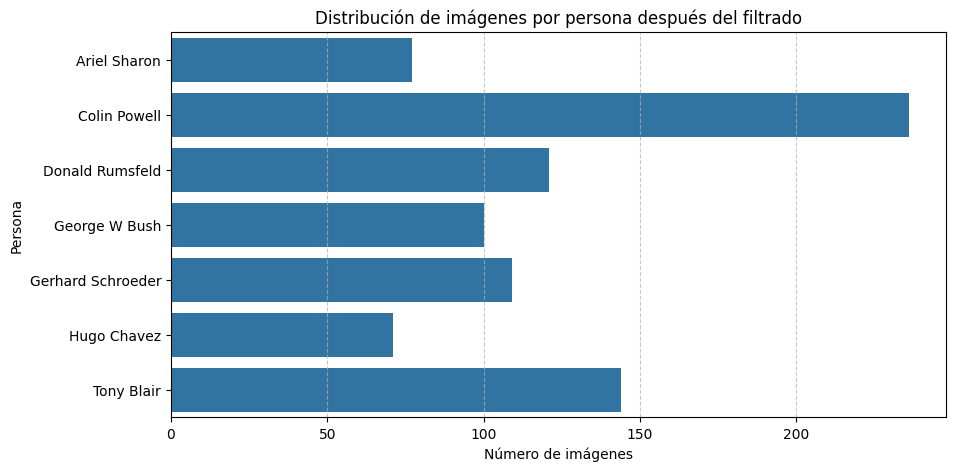

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ===============================================================
# 📊 2. DISTRIBUCIÓN DE IMÁGENES POR PERSONA
# ===============================================================

# 1. Obtenemos los índices únicos y sus conteos
unique, counts = np.unique(y_filtered, return_counts=True)

# 2. CORRECCIÓN: Seleccionamos solo los nombres que corresponden a esos índices únicos.
# Esto asegura que la lista de nombres tenga EXACTAMENTE el mismo largo que la lista de conteos.
names_present = target_names_filtered[unique]

plt.figure(figsize=(10, 5))

# Usamos 'names_present' en lugar de 'target_names_filtered'
sns.barplot(x=counts, y=names_present)

plt.xlabel("Número de imágenes")
plt.ylabel("Persona")
plt.title("Distribución de imágenes por persona después del filtrado")
plt.grid(axis='x', linestyle='--', alpha=0.7) # Agregué una grilla suave para mejor lectura
plt.show()

##05_Reducción de dimensionalidad PCA

El PCA permite una reducción de dimensión sin perder información en el proceso, este proceso se realiza para permitir un mejor rendimniento ya que las imagenes cuentas con miles de pixeles y el analizar uno a uno generar un gasto computacional mayor.

In [82]:
from sklearn.decomposition import PCA

pca = PCA(n_components=150, whiten=True, random_state=42)


##06_Clasificar usando un SVM y kernel RBF


En nuestro modelo de reconocimiento facial, el SVM con kernel RBF se encarga de reconocer a qué persona pertenece una imagen. Primero, el modelo recibe los rostros convertidos en números y busca patrones que diferencien a cada individuo. El SVM aprende a separar las caras de distintas personas trazando límites entre ellas. Como los rostros no se distinguen con líneas rectas, el kernel RBF permite crear fronteras curvas y flexibles que se adaptan mejor a las diferencias reales entre las caras. Así, el modelo puede identificar correctamente a una persona, incluso si la imagen cambia un poco en expresión o iluminación.


In [83]:
from sklearn.svm import SVC

svc = SVC(kernel='linear', probability=True)


##07_Creamor un pipeline para que los algoritmos PCA y SVM estén automatizados

In [84]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(pca, svc)

##08_Entrenamiento y Evaluación del modelo



In [85]:
model.fit(X_train_filtered, y_train_filtered)

Pipeline(steps=[('pca', PCA(n_components=150, random_state=42, whiten=True)),
                ('svc', SVC(kernel='linear', probability=True))])

In [86]:
y_pred = model.predict(X_test_filtered)

etiquetas_reales = np.unique(np.concatenate((y_test_filtered, y_pred)))

# 2. Filtrar la lista de nombres para quedarnos solo con los que coinciden con esas etiquetas
# Esto elimina cualquier nombre "fantasma" que se haya colado en la lista por error
nombres_reales = target_names_filtered[etiquetas_reales]

print(f"Clases encontradas en los datos: {len(etiquetas_reales)}")
print(f"Nombres disponibles para reportar: {len(nombres_reales)}")
print("-" * 30)

# 3. Generar el reporte usando SOLO lo que está verificado
print(classification_report(y_test_filtered, y_pred,
                            labels=etiquetas_reales,
                            target_names=nombres_reales))




Clases encontradas en los datos: 7
Nombres disponibles para reportar: 7
------------------------------
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.95      0.86        19
     Colin Powell       0.80      0.88      0.84        59
  Donald Rumsfeld       0.74      0.81      0.77        31
    George W Bush       0.76      0.52      0.62        25
Gerhard Schroeder       0.74      0.63      0.68        27
      Hugo Chavez       0.79      0.83      0.81        18
       Tony Blair       0.79      0.75      0.77        36

         accuracy                           0.78       215
        macro avg       0.77      0.77      0.76       215
     weighted avg       0.78      0.78      0.77       215



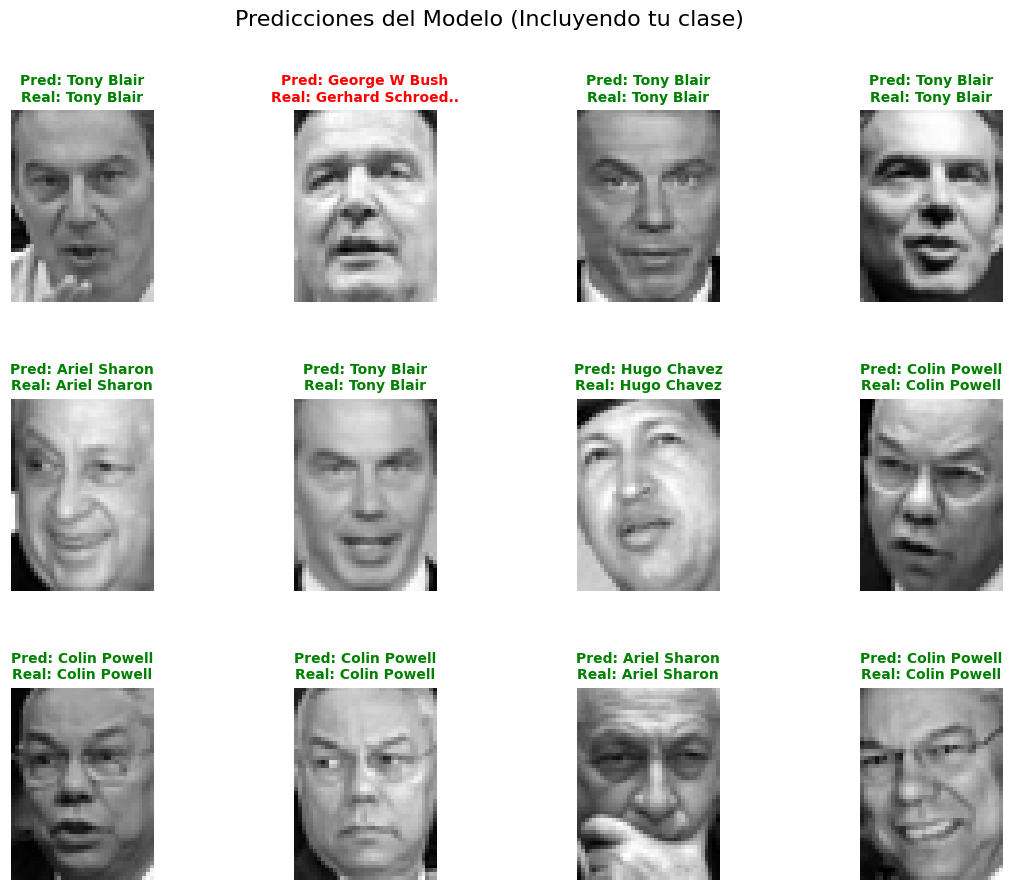

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURACIÓN DE LA VISUALIZACIÓN
# =============================================================================
# 1. Definimos cuántas fotos tuyas queremos ver MÍNIMO en el grid
cantidad_mis_fotos = 4
total_imagenes = 12  # Grid de 3x4

# 2. Identificamos tu clase (Asumimos que es la última que se agregó)
# Si sabes el nombre exacto, podrías usar: np.where(target_names_filtered == "Tu Nombre")[0][0]
mi_id_clase = len(target_names_filtered) - 1

# 3. Filtramos los índices en el TEST set
indices_mios = np.where(y_test_filtered == mi_id_clase)[0]
indices_otros = np.where(y_test_filtered != mi_id_clase)[0]

# =============================================================================
# SELECCIÓN DE IMÁGENES (Forzando a que salgas tú)
# =============================================================================
# Seleccionamos al azar 'n' fotos tuyas (o todas las que haya si son menos de 4)
n_mios = min(len(indices_mios), cantidad_mis_fotos)
seleccion_mios = np.random.choice(indices_mios, n_mios, replace=False)

# El resto del grid lo llenamos con los otros personajes
n_otros = total_imagenes - n_mios
seleccion_otros = np.random.choice(indices_otros, n_otros, replace=False)

# Unimos y mezclamos para que no salgas siempre al principio
indices_visualizar = np.concatenate([seleccion_mios, seleccion_otros])
np.random.shuffle(indices_visualizar)

# =============================================================================
# GRAFICAR RESULTADOS
# =============================================================================
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
plt.subplots_adjust(hspace=0.5) # Espacio vertical para que no se peguen los textos

for i, ax in enumerate(axes.flat):
    if i < len(indices_visualizar):
        idx = indices_visualizar[i] # Índice real en X_test

        # Obtener imagen y predicción
        # Usamos reshape con h, w si los tienes guardados, o extraemos de shapes originales
        h_img, w_img = images.shape[1], images.shape[2]
        imagen = X_test_filtered[idx].reshape(h_img, w_img)

        prediccion = y_pred[idx]
        real = y_test_filtered[idx]

        # Mostrar imagen
        ax.imshow(imagen, cmap="gray")

        # Definir color: Verde si acertó, Rojo si falló
        color_texto = "green" if prediccion == real else "red"

        # Crear etiqueta
        # IMPORTANTE: Usar target_names_filtered (la lista actualizada con tu nombre)
        nombre_pred = target_names_filtered[prediccion]
        nombre_real = target_names_filtered[real]

        # Si el nombre es muy largo, lo cortamos un poco para que entre
        nombre_pred = (nombre_pred[:15] + '..') if len(nombre_pred) > 15 else nombre_pred
        nombre_real = (nombre_real[:15] + '..') if len(nombre_real) > 15 else nombre_real

        ax.set_title(f"Pred: {nombre_pred}\nReal: {nombre_real}",
                     fontsize=10, color=color_texto, fontweight='bold')

    ax.axis("off")

plt.suptitle("Predicciones del Modelo (Incluyendo tu clase)", fontsize=16)
plt.show()

# **Pruebas de Machine Learning**

## Gaussian Naive Bayes

In [88]:
gnb = GaussianNB()

In [89]:
gnb.fit(X_train_filtered, y_train_filtered)

GaussianNB()

In [90]:
from sklearn.metrics import classification_report

y_pred = gnb.predict(X_test_filtered)

etiquetas_reales = np.unique(np.concatenate((y_test_filtered, y_pred)))

nombres_reales = target_names_filtered[etiquetas_reales]

print(f"Clases encontradas en los datos: {len(etiquetas_reales)}")
print(f"Nombres disponibles para reportar: {len(nombres_reales)}")
print("-" * 30)

# 3. Generar el reporte usando SOLO lo que está verificado
print(classification_report(y_test_filtered, y_pred,
                            labels=etiquetas_reales,
                            target_names=nombres_reales))

Clases encontradas en los datos: 7
Nombres disponibles para reportar: 7
------------------------------
                   precision    recall  f1-score   support

     Ariel Sharon       0.18      0.26      0.21        19
     Colin Powell       0.66      0.46      0.54        59
  Donald Rumsfeld       0.65      0.35      0.46        31
    George W Bush       0.35      0.52      0.42        25
Gerhard Schroeder       0.29      0.44      0.35        27
      Hugo Chavez       0.34      0.56      0.43        18
       Tony Blair       0.55      0.33      0.41        36

         accuracy                           0.42       215
        macro avg       0.43      0.42      0.40       215
     weighted avg       0.49      0.42      0.43       215



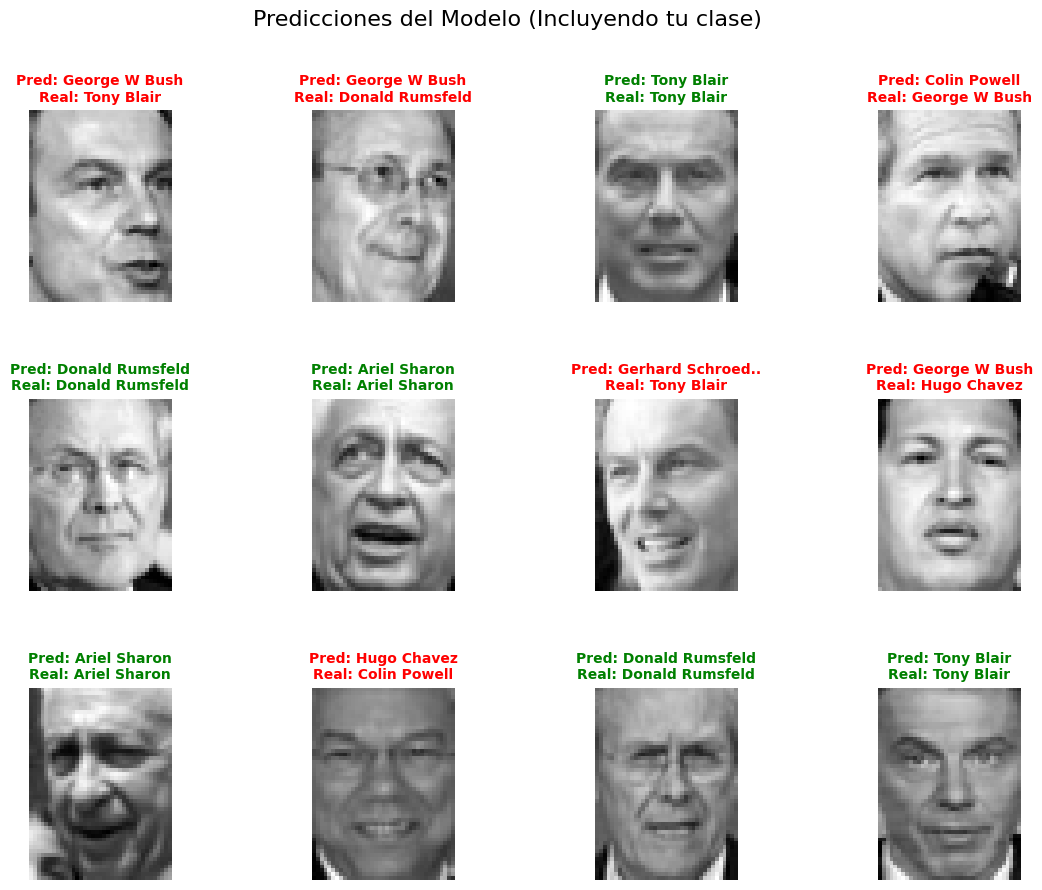

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURACIÓN DE LA VISUALIZACIÓN
# =============================================================================
# 1. Definimos cuántas fotos tuyas queremos ver MÍNIMO en el grid
cantidad_mis_fotos = 4
total_imagenes = 12  # Grid de 3x4

# 2. Identificamos tu clase (Asumimos que es la última que se agregó)
# Si sabes el nombre exacto, podrías usar: np.where(target_names_filtered == "Tu Nombre")[0][0]
mi_id_clase = len(target_names_filtered) - 1

# 3. Filtramos los índices en el TEST set
indices_mios = np.where(y_test_filtered == mi_id_clase)[0]
indices_otros = np.where(y_test_filtered != mi_id_clase)[0]

# =============================================================================
# SELECCIÓN DE IMÁGENES (Forzando a que salgas tú)
# =============================================================================
# Seleccionamos al azar 'n' fotos tuyas (o todas las que haya si son menos de 4)
n_mios = min(len(indices_mios), cantidad_mis_fotos)
seleccion_mios = np.random.choice(indices_mios, n_mios, replace=False)

# El resto del grid lo llenamos con los otros personajes
n_otros = total_imagenes - n_mios
seleccion_otros = np.random.choice(indices_otros, n_otros, replace=False)

# Unimos y mezclamos para que no salgas siempre al principio
indices_visualizar = np.concatenate([seleccion_mios, seleccion_otros])
np.random.shuffle(indices_visualizar)

# =============================================================================
# GRAFICAR RESULTADOS
# =============================================================================
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
plt.subplots_adjust(hspace=0.5) # Espacio vertical para que no se peguen los textos

for i, ax in enumerate(axes.flat):
    if i < len(indices_visualizar):
        idx = indices_visualizar[i] # Índice real en X_test

        # Obtener imagen y predicción
        # Usamos reshape con h, w si los tienes guardados, o extraemos de shapes originales
        h_img, w_img = images.shape[1], images.shape[2]
        imagen = X_test_filtered[idx].reshape(h_img, w_img)

        prediccion = y_pred[idx]
        real = y_test_filtered[idx]

        # Mostrar imagen
        ax.imshow(imagen, cmap="gray")

        # Definir color: Verde si acertó, Rojo si falló
        color_texto = "green" if prediccion == real else "red"

        # Crear etiqueta
        # IMPORTANTE: Usar target_names_filtered (la lista actualizada con tu nombre)
        nombre_pred = target_names_filtered[prediccion]
        nombre_real = target_names_filtered[real]

        # Si el nombre es muy largo, lo cortamos un poco para que entre
        nombre_pred = (nombre_pred[:15] + '..') if len(nombre_pred) > 15 else nombre_pred
        nombre_real = (nombre_real[:15] + '..') if len(nombre_real) > 15 else nombre_real

        ax.set_title(f"Pred: {nombre_pred}\nReal: {nombre_real}",
                     fontsize=10, color=color_texto, fontweight='bold')

    ax.axis("off")

plt.suptitle("Predicciones del Modelo (Incluyendo tu clase)", fontsize=16)
plt.show()

## Random Forest

In [92]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=50)

In [93]:
rf.fit(X_train_filtered, y_train_filtered)

RandomForestClassifier(max_depth=50)

In [94]:
from sklearn.metrics import classification_report

y_pred = rf.predict(X_test_filtered)

etiquetas_reales = np.unique(np.concatenate((y_test_filtered, y_pred)))

nombres_reales = target_names_filtered[etiquetas_reales]

print(f"Clases encontradas en los datos: {len(etiquetas_reales)}")
print(f"Nombres disponibles para reportar: {len(nombres_reales)}")
print("-" * 30)

# 3. Generar el reporte usando SOLO lo que está verificado
print(classification_report(y_test_filtered, y_pred,
                            labels=etiquetas_reales,
                            target_names=nombres_reales))

Clases encontradas en los datos: 7
Nombres disponibles para reportar: 7
------------------------------
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.11      0.18        19
     Colin Powell       0.56      0.93      0.70        59
  Donald Rumsfeld       0.71      0.39      0.50        31
    George W Bush       0.57      0.32      0.41        25
Gerhard Schroeder       0.48      0.59      0.53        27
      Hugo Chavez       0.79      0.61      0.69        18
       Tony Blair       0.71      0.69      0.70        36

         accuracy                           0.60       215
        macro avg       0.64      0.52      0.53       215
     weighted avg       0.63      0.60      0.57       215



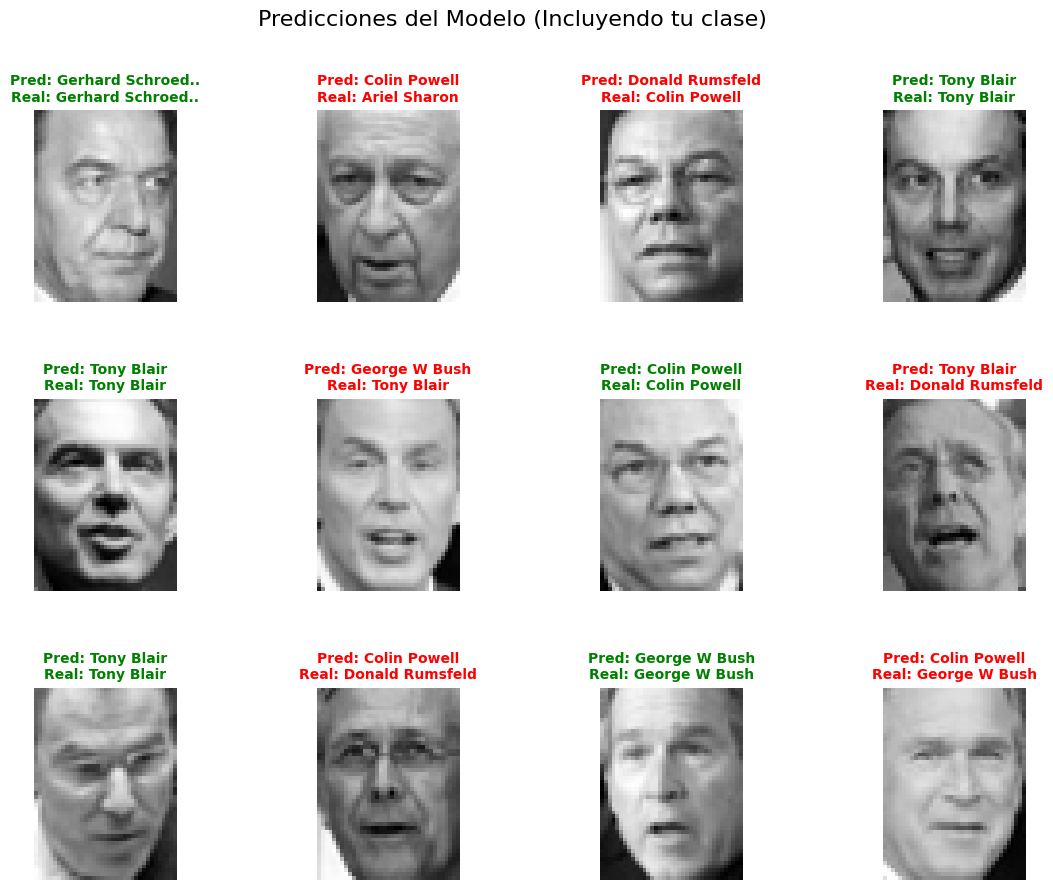

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURACIÓN DE LA VISUALIZACIÓN
# =============================================================================
# 1. Definimos cuántas fotos tuyas queremos ver MÍNIMO en el grid
cantidad_mis_fotos = 4
total_imagenes = 12  # Grid de 3x4

# 2. Identificamos tu clase (Asumimos que es la última que se agregó)
# Si sabes el nombre exacto, podrías usar: np.where(target_names_filtered == "Tu Nombre")[0][0]
mi_id_clase = len(target_names_filtered) - 1

# 3. Filtramos los índices en el TEST set
indices_mios = np.where(y_test_filtered == mi_id_clase)[0]
indices_otros = np.where(y_test_filtered != mi_id_clase)[0]

# =============================================================================
# SELECCIÓN DE IMÁGENES (Forzando a que salgas tú)
# =============================================================================
# Seleccionamos al azar 'n' fotos tuyas (o todas las que haya si son menos de 4)
n_mios = min(len(indices_mios), cantidad_mis_fotos)
seleccion_mios = np.random.choice(indices_mios, n_mios, replace=False)

# El resto del grid lo llenamos con los otros personajes
n_otros = total_imagenes - n_mios
seleccion_otros = np.random.choice(indices_otros, n_otros, replace=False)

# Unimos y mezclamos para que no salgas siempre al principio
indices_visualizar = np.concatenate([seleccion_mios, seleccion_otros])
np.random.shuffle(indices_visualizar)

# =============================================================================
# GRAFICAR RESULTADOS
# =============================================================================
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
plt.subplots_adjust(hspace=0.5) # Espacio vertical para que no se peguen los textos

for i, ax in enumerate(axes.flat):
    if i < len(indices_visualizar):
        idx = indices_visualizar[i] # Índice real en X_test

        # Obtener imagen y predicción
        # Usamos reshape con h, w si los tienes guardados, o extraemos de shapes originales
        h_img, w_img = images.shape[1], images.shape[2]
        imagen = X_test_filtered[idx].reshape(h_img, w_img)

        prediccion = y_pred[idx]
        real = y_test_filtered[idx]

        # Mostrar imagen
        ax.imshow(imagen, cmap="gray")

        # Definir color: Verde si acertó, Rojo si falló
        color_texto = "green" if prediccion == real else "red"

        # Crear etiqueta
        # IMPORTANTE: Usar target_names_filtered (la lista actualizada con tu nombre)
        nombre_pred = target_names_filtered[prediccion]
        nombre_real = target_names_filtered[real]

        # Si el nombre es muy largo, lo cortamos un poco para que entre
        nombre_pred = (nombre_pred[:15] + '..') if len(nombre_pred) > 15 else nombre_pred
        nombre_real = (nombre_real[:15] + '..') if len(nombre_real) > 15 else nombre_real

        ax.set_title(f"Pred: {nombre_pred}\nReal: {nombre_real}",
                     fontsize=10, color=color_texto, fontweight='bold')

    ax.axis("off")

plt.suptitle("Predicciones del Modelo (Incluyendo tu clase)", fontsize=16)
plt.show()

## Decision Tree

In [96]:
dt = DecisionTreeClassifier(max_depth=50)

In [97]:
dt.fit(X_train_filtered, y_train_filtered)

DecisionTreeClassifier(max_depth=50)

In [98]:
from sklearn.metrics import classification_report

y_pred = dt.predict(X_test_filtered)

etiquetas_reales = np.unique(np.concatenate((y_test_filtered, y_pred)))

nombres_reales = target_names_filtered[etiquetas_reales]

print(f"Clases encontradas en los datos: {len(etiquetas_reales)}")
print(f"Nombres disponibles para reportar: {len(nombres_reales)}")
print("-" * 30)

# 3. Generar el reporte usando SOLO lo que está verificado
print(classification_report(y_test_filtered, y_pred,
                            labels=etiquetas_reales,
                            target_names=nombres_reales))

Clases encontradas en los datos: 7
Nombres disponibles para reportar: 7
------------------------------
                   precision    recall  f1-score   support

     Ariel Sharon       0.20      0.21      0.21        19
     Colin Powell       0.48      0.49      0.48        59
  Donald Rumsfeld       0.28      0.29      0.29        31
    George W Bush       0.23      0.20      0.21        25
Gerhard Schroeder       0.25      0.22      0.24        27
      Hugo Chavez       0.56      0.50      0.53        18
       Tony Blair       0.35      0.39      0.37        36

         accuracy                           0.35       215
        macro avg       0.34      0.33      0.33       215
     weighted avg       0.35      0.35      0.35       215



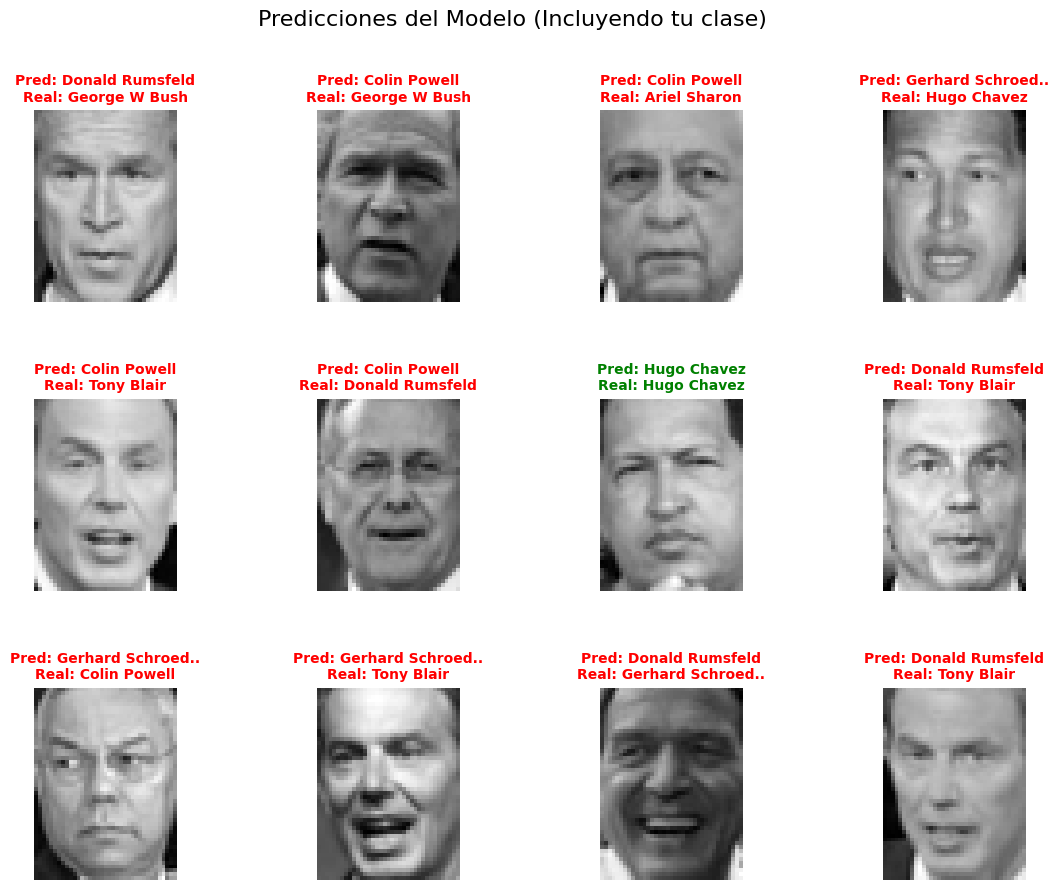

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURACIÓN DE LA VISUALIZACIÓN
# =============================================================================
# 1. Definimos cuántas fotos tuyas queremos ver MÍNIMO en el grid
cantidad_mis_fotos = 4
total_imagenes = 12  # Grid de 3x4

# 2. Identificamos tu clase (Asumimos que es la última que se agregó)
# Si sabes el nombre exacto, podrías usar: np.where(target_names_filtered == "Tu Nombre")[0][0]
mi_id_clase = len(target_names_filtered) - 1

# 3. Filtramos los índices en el TEST set
indices_mios = np.where(y_test_filtered == mi_id_clase)[0]
indices_otros = np.where(y_test_filtered != mi_id_clase)[0]

# =============================================================================
# SELECCIÓN DE IMÁGENES (Forzando a que salgas tú)
# =============================================================================
# Seleccionamos al azar 'n' fotos tuyas (o todas las que haya si son menos de 4)
n_mios = min(len(indices_mios), cantidad_mis_fotos)
seleccion_mios = np.random.choice(indices_mios, n_mios, replace=False)

# El resto del grid lo llenamos con los otros personajes
n_otros = total_imagenes - n_mios
seleccion_otros = np.random.choice(indices_otros, n_otros, replace=False)

# Unimos y mezclamos para que no salgas siempre al principio
indices_visualizar = np.concatenate([seleccion_mios, seleccion_otros])
np.random.shuffle(indices_visualizar)

# =============================================================================
# GRAFICAR RESULTADOS
# =============================================================================
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
plt.subplots_adjust(hspace=0.5) # Espacio vertical para que no se peguen los textos

for i, ax in enumerate(axes.flat):
    if i < len(indices_visualizar):
        idx = indices_visualizar[i] # Índice real en X_test

        # Obtener imagen y predicción
        # Usamos reshape con h, w si los tienes guardados, o extraemos de shapes originales
        h_img, w_img = images.shape[1], images.shape[2]
        imagen = X_test_filtered[idx].reshape(h_img, w_img)

        prediccion = y_pred[idx]
        real = y_test_filtered[idx]

        # Mostrar imagen
        ax.imshow(imagen, cmap="gray")

        # Definir color: Verde si acertó, Rojo si falló
        color_texto = "green" if prediccion == real else "red"

        # Crear etiqueta
        # IMPORTANTE: Usar target_names_filtered (la lista actualizada con tu nombre)
        nombre_pred = target_names_filtered[prediccion]
        nombre_real = target_names_filtered[real]

        # Si el nombre es muy largo, lo cortamos un poco para que entre
        nombre_pred = (nombre_pred[:15] + '..') if len(nombre_pred) > 15 else nombre_pred
        nombre_real = (nombre_real[:15] + '..') if len(nombre_real) > 15 else nombre_real

        ax.set_title(f"Pred: {nombre_pred}\nReal: {nombre_real}",
                     fontsize=10, color=color_texto, fontweight='bold')

    ax.axis("off")

plt.suptitle("Predicciones del Modelo (Incluyendo tu clase)", fontsize=16)
plt.show()

 ## SVM

In [100]:
svc = SVC(kernel='linear', probability=True)

Nota: No uses rbf para embeddings de alto nivel — tiende a sobreajustar.

In [101]:
svc.fit(X_train_filtered, y_train_filtered)

SVC(kernel='linear', probability=True)

In [102]:
from sklearn.metrics import classification_report

y_pred = svc.predict(X_test_filtered)

etiquetas_reales = np.unique(np.concatenate((y_test_filtered, y_pred)))

nombres_reales = target_names_filtered[etiquetas_reales]

print(f"Clases encontradas en los datos: {len(etiquetas_reales)}")
print(f"Nombres disponibles para reportar: {len(nombres_reales)}")
print("-" * 30)

# 3. Generar el reporte usando SOLO lo que está verificado
print(classification_report(y_test_filtered, y_pred,
                            labels=etiquetas_reales,
                            target_names=nombres_reales))

Clases encontradas en los datos: 7
Nombres disponibles para reportar: 7
------------------------------
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        19
     Colin Powell       0.27      1.00      0.43        59
  Donald Rumsfeld       0.00      0.00      0.00        31
    George W Bush       0.00      0.00      0.00        25
Gerhard Schroeder       0.00      0.00      0.00        27
      Hugo Chavez       0.00      0.00      0.00        18
       Tony Blair       0.00      0.00      0.00        36

         accuracy                           0.27       215
        macro avg       0.04      0.14      0.06       215
     weighted avg       0.08      0.27      0.12       215



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


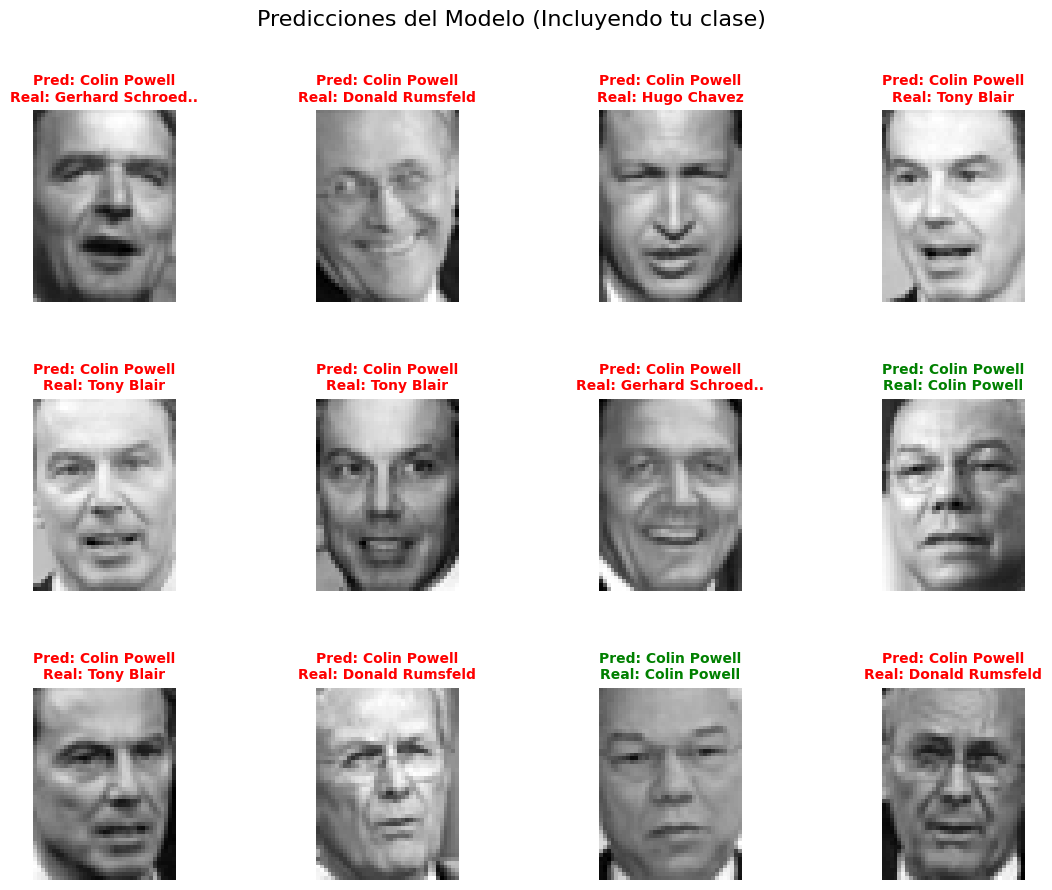

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURACIÓN DE LA VISUALIZACIÓN
# =============================================================================
# 1. Definimos cuántas fotos tuyas queremos ver MÍNIMO en el grid
cantidad_mis_fotos = 4
total_imagenes = 12  # Grid de 3x4

# 2. Identificamos tu clase (Asumimos que es la última que se agregó)
# Si sabes el nombre exacto, podrías usar: np.where(target_names_filtered == "Tu Nombre")[0][0]
mi_id_clase = len(target_names_filtered) - 1

# 3. Filtramos los índices en el TEST set
indices_mios = np.where(y_test_filtered == mi_id_clase)[0]
indices_otros = np.where(y_test_filtered != mi_id_clase)[0]

# =============================================================================
# SELECCIÓN DE IMÁGENES (Forzando a que salgas tú)
# =============================================================================
# Seleccionamos al azar 'n' fotos tuyas (o todas las que haya si son menos de 4)
n_mios = min(len(indices_mios), cantidad_mis_fotos)
seleccion_mios = np.random.choice(indices_mios, n_mios, replace=False)

# El resto del grid lo llenamos con los otros personajes
n_otros = total_imagenes - n_mios
seleccion_otros = np.random.choice(indices_otros, n_otros, replace=False)

# Unimos y mezclamos para que no salgas siempre al principio
indices_visualizar = np.concatenate([seleccion_mios, seleccion_otros])
np.random.shuffle(indices_visualizar)

# =============================================================================
# GRAFICAR RESULTADOS
# =============================================================================
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
plt.subplots_adjust(hspace=0.5) # Espacio vertical para que no se peguen los textos

for i, ax in enumerate(axes.flat):
    if i < len(indices_visualizar):
        idx = indices_visualizar[i] # Índice real en X_test

        # Obtener imagen y predicción
        # Usamos reshape con h, w si los tienes guardados, o extraemos de shapes originales
        h_img, w_img = images.shape[1], images.shape[2]
        imagen = X_test_filtered[idx].reshape(h_img, w_img)

        prediccion = y_pred[idx]
        real = y_test_filtered[idx]

        # Mostrar imagen
        ax.imshow(imagen, cmap="gray")

        # Definir color: Verde si acertó, Rojo si falló
        color_texto = "green" if prediccion == real else "red"

        # Crear etiqueta
        # IMPORTANTE: Usar target_names_filtered (la lista actualizada con tu nombre)
        nombre_pred = target_names_filtered[prediccion]
        nombre_real = target_names_filtered[real]

        # Si el nombre es muy largo, lo cortamos un poco para que entre
        nombre_pred = (nombre_pred[:15] + '..') if len(nombre_pred) > 15 else nombre_pred
        nombre_real = (nombre_real[:15] + '..') if len(nombre_real) > 15 else nombre_real

        ax.set_title(f"Pred: {nombre_pred}\nReal: {nombre_real}",
                     fontsize=10, color=color_texto, fontweight='bold')

    ax.axis("off")

plt.suptitle("Predicciones del Modelo (Incluyendo tu clase)", fontsize=16)
plt.show()

Nota:

**Modelos SVC sin PCA**

El kernel lineal de SVC sin reducción de dimensionalidad suele tener problemas para separar clases en datos de imágenes, especialmente cuando el número de dimensiones (pixeles) es muy alto.

En datasets como LFW, cada imagen puede tener miles de características (una por píxel), y muchas de ellas no aportan información relevante, lo que genera ruido y dificulta que el SVC aprenda fronteras óptimas.

Cuando el modelo no logra separar bien las clases, puede terminar prediciendo únicamente una o unas pocas clases mayoritarias, ignorando completamente las menos representadas, de ahí la advertencia de "precision ill-defined".

**SVC con PCA**

PCA (Análisis de Componentes Principales) reduce la dimensionalidad del problema, extrayendo las características más relevantes. Esto filtra el ruido y concentra la información en menos dimensiones.

Gracias a esto, el SVC puede encontrar fronteras de decisión más claras y no se ve tan afectado por la “maldición de la dimensionalidad” (demasiadas variables irrelevantes).

El resultado es que el modelo predice más clases correctamente y no deja etiquetas completamente sin predecir, eliminando la advertencia.

**Resumen**

Sin PCA: El SVC lineal no logra separar bien las clases por exceso de dimensiones y ruido, llevando a que ignore algunas clases.

Con PCA: La reducción del espacio a las componentes principales permite que el SVC capture mejor las relaciones y prediga correctamente todas o la mayoría de las clases.

# **DEEP LEARNING**

In [105]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

In [106]:
y_train_categorical = to_categorical(y_train_filtered)
y_test_categorical = to_categorical(y_test_filtered)

In [107]:
n_clases = len(np.unique(y_filtered))
print(n_clases)

7


In [108]:
model_dl = Sequential([
    Input(shape=(X_filtered.shape[1],)),           # Capa de entrada recomendada
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(len(target_names_filtered), activation='softmax')
])

model_dl.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │       947,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,116,423 (4.26 MB)

 Trainable params: 1,114,631 (4.25 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [125]:
optimizer = Adam(learning_rate=0.001)

model_dl.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # Mantener si usas labels enteros
    metrics=['accuracy']
)

# Callbacks para mejorar el entrenamiento
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Entrenamiento con callbacks
history = model_dl.fit(
    X_train_filtered,  # o X_train_scaled
    y_train_filtered,
    epochs=100,  # Más épocas con early stopping
    batch_size=32,
    validation_data=(X_test_filtered, y_test_filtered),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9575 - loss: 0.6616 - val_accuracy: 0.3814 - val_loss: 4.3211 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9521 - loss: 0.5994 - val_accuracy: 0.7116 - val_loss: 1.4336 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9590 - loss: 0.6093 - val_accuracy: 0.5116 - val_loss: 2.9995 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9488 - loss: 0.6194 - val_accuracy: 0.4047 - val_loss: 3.9197 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9439 - loss: 0.6497 - val_accuracy: 0.6698 - val_loss: 2.0008 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9165 - loss: 0.6607 - val_accuracy: 0.3907 - val_loss: 2.6754 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9193 - loss: 0.7052
E

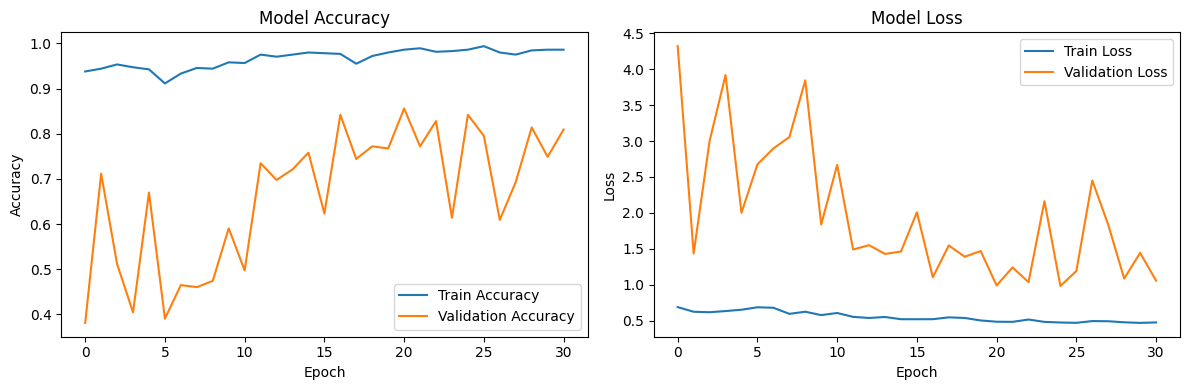

In [126]:
import matplotlib.pyplot as plt

# Graficar evolución del entrenamiento
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


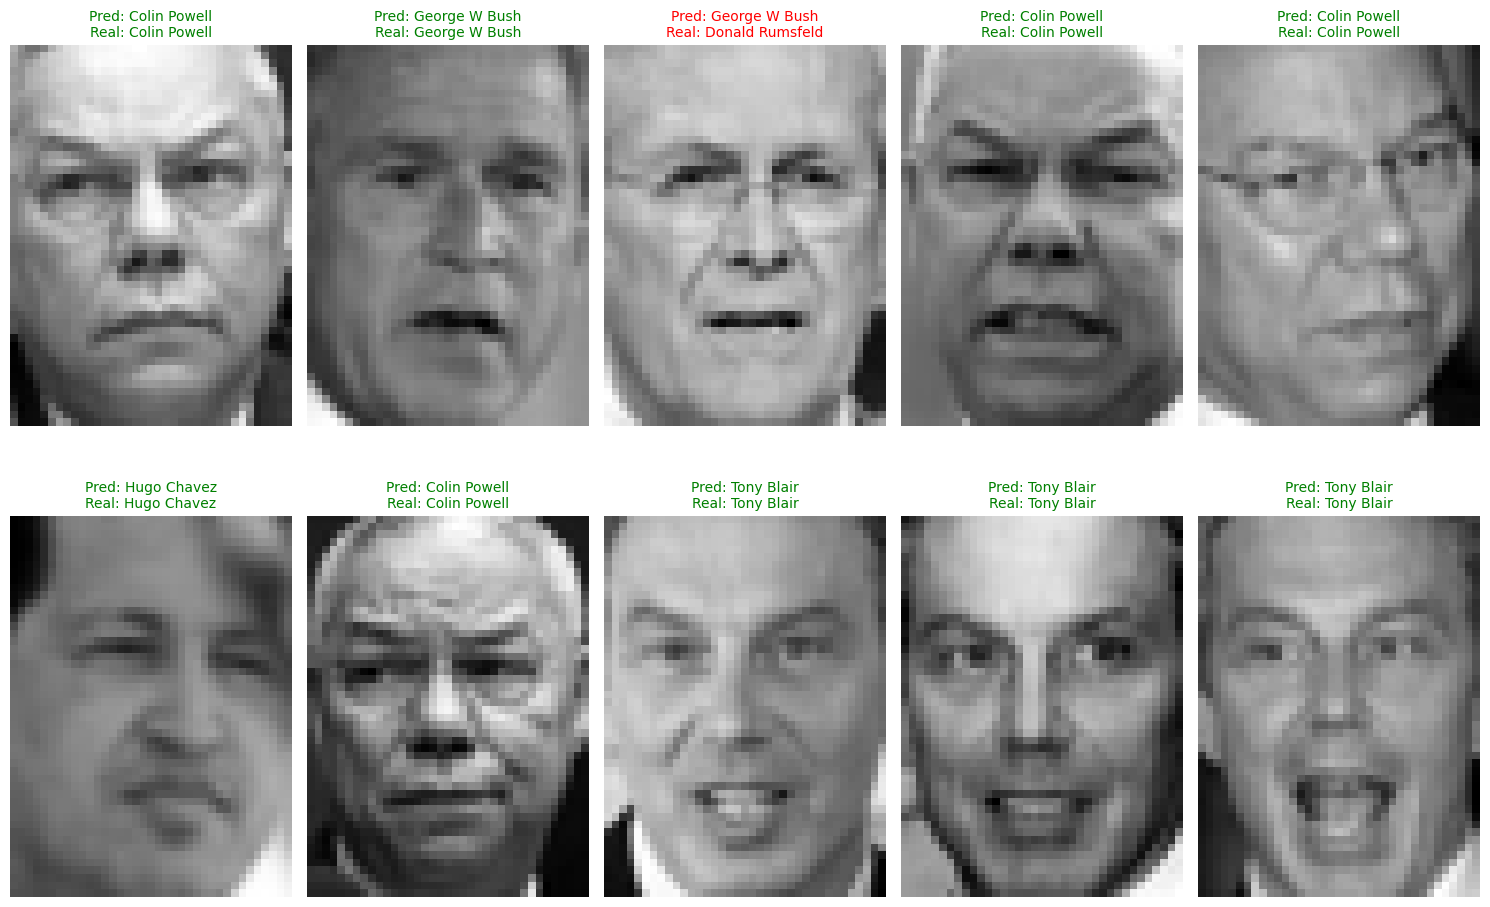

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# Hacer predicciones
y_pred = model_dl.predict(X_test_filtered)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtener los nombres reales de las clases
class_names = target_names_filtered

# Obtener dimensiones correctas de las imágenes
img_height = images_filtered.shape[1]
img_width = images_filtered.shape[2]

# Mostrar predicciones CORREGIDO
plt.figure(figsize=(15, 10))
for i in range(min(10, len(X_test_filtered))):  # Mostrar máximo 10 imágenes
    plt.subplot(2, 5, i + 1)

    # Reconstruir la imagen con las dimensiones correctas
    img = X_test_filtered[i].reshape(img_height, img_width)

    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # Obtener predicción y etiqueta real
    pred_label = class_names[y_pred_classes[i]]
    true_label = class_names[y_test_filtered[i]]

    # Color del texto: verde si es correcto, rojo si es incorrecto
    color = 'green' if pred_label == true_label else 'red'

    plt.title(f'Pred: {pred_label}\nReal: {true_label}',
              color=color, fontsize=10)

plt.tight_layout()
plt.show()

## **Metricas**

In [128]:
# Hacer predicciones
y_pred = model_dl.predict(X_test_filtered)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular métricas
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_filtered, y_pred_classes, average=None
)

# Crear DataFrame con las métricas
metrics_df = pd.DataFrame({
    'Clase': target_names_filtered,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("MÉTRICAS POR CLASE:")
print("=" * 60)
print(metrics_df.round(3))

# Mostrar reporte de clasificación completo
print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN COMPLETO")
print("=" * 60)
print(classification_report(y_test_filtered, y_pred_classes,
                          target_names=target_names_filtered))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
MÉTRICAS POR CLASE:
               Clase  Precision  Recall  F1-Score  Support
0       Ariel Sharon      0.750   0.789     0.769       19
1       Colin Powell      0.982   0.915     0.947       59
2    Donald Rumsfeld      0.821   0.742     0.780       31
3      George W Bush      0.741   0.800     0.769       25
4  Gerhard Schroeder      0.913   0.778     0.840       27
5        Hugo Chavez      0.944   0.944     0.944       18
6         Tony Blair      0.773   0.944     0.850       36

REPORTE DE CLASIFICACIÓN COMPLETO
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.79      0.77        19
     Colin Powell       0.98      0.92      0.95        59
  Donald Rumsfeld       0.82      0.74      0.78        31
    George W Bush       0.74      0.80      0.77        25
Gerhard Schroeder       0.91      0.78      0.84        27
      Hugo Chavez       0.94      0.94      0.94        18
       Tony Blair    

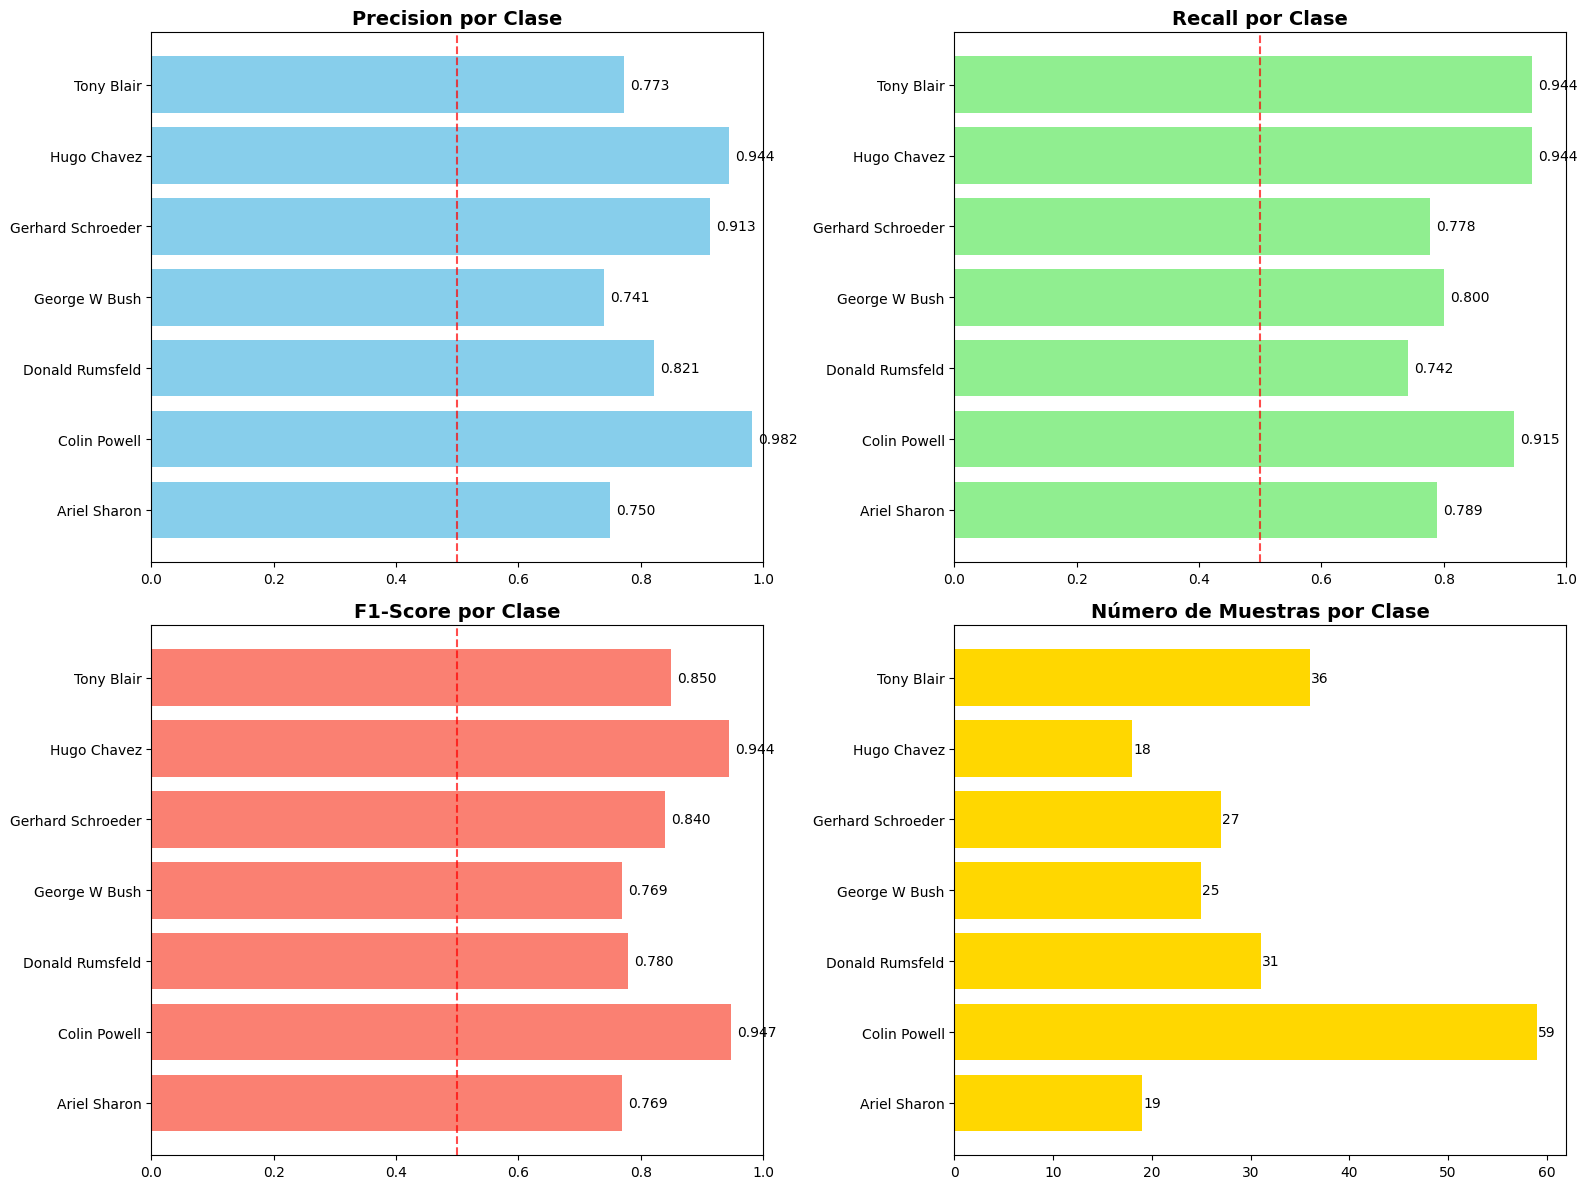

In [129]:
# Gráfico de métricas por clase
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Precision por clase
axes[0, 0].barh(metrics_df['Clase'], metrics_df['Precision'], color='skyblue')
axes[0, 0].set_title('Precision por Clase', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim(0, 1)
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral 0.5')
for i, v in enumerate(metrics_df['Precision']):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Recall por clase
axes[0, 1].barh(metrics_df['Clase'], metrics_df['Recall'], color='lightgreen')
axes[0, 1].set_title('Recall por Clase', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim(0, 1)
axes[0, 1].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral 0.5')
for i, v in enumerate(metrics_df['Recall']):
    axes[0, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

# F1-Score por clase
axes[1, 0].barh(metrics_df['Clase'], metrics_df['F1-Score'], color='salmon')
axes[1, 0].set_title('F1-Score por Clase', fontsize=14, fontweight='bold')
axes[1, 0].set_xlim(0, 1)
axes[1, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral 0.5')
for i, v in enumerate(metrics_df['F1-Score']):
    axes[1, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Support (número de muestras)
axes[1, 1].barh(metrics_df['Clase'], metrics_df['Support'], color='gold')
axes[1, 1].set_title('Número de Muestras por Clase', fontsize=14, fontweight='bold')
for i, v in enumerate(metrics_df['Support']):
    axes[1, 1].text(v + 0.1, i, str(int(v)), va='center')

plt.tight_layout()
plt.show()

In [130]:
precision_avg = precision_recall_fscore_support(
    y_test_filtered, y_pred_classes, average='macro'
)

precision_weighted = precision_recall_fscore_support(
    y_test_filtered, y_pred_classes, average='weighted'
)

# Reporte ejecutivo final
print("REPORTE EJECUTIVO - DESEMPEÑO DEL MODELO")
print("=" * 70)

# Métricas generales
accuracy = np.mean(y_pred_classes == y_test_filtered)
macro_f1 = precision_avg[2]
weighted_f1 = precision_weighted[2]

print(f"\n📊 MÉTRICAS GLOBALES:")
print(f"   • Accuracy:          {accuracy:.3f}")
print(f"   • Macro F1-Score:    {macro_f1:.3f}")
print(f"   • Weighted F1-Score: {weighted_f1:.3f}")

# Mejores y peores clases por F1-Score
best_class_idx = np.argmax(metrics_df['F1-Score'])
worst_class_idx = np.argmin(metrics_df['F1-Score'])

print(f"\n🏆 MEJOR CLASE:")
print(f"   • {metrics_df.iloc[best_class_idx]['Clase']}: F1-Score = {metrics_df.iloc[best_class_idx]['F1-Score']:.3f}")

print(f"\n⚠️  CLASE CON MÁS DIFICULTAD:")
print(f"   • {metrics_df.iloc[worst_class_idx]['Clase']}: F1-Score = {metrics_df.iloc[worst_class_idx]['F1-Score']:.3f}")

# Clases con buen y mal desempeño
good_classes = metrics_df[metrics_df['F1-Score'] >= 0.7]
bad_classes = metrics_df[metrics_df['F1-Score'] < 0.5]

print(f"\n✅ CLASES CON BUEN DESEMPEÑO (F1 ≥ 0.7): {len(good_classes)}")
for _, row in good_classes.iterrows():
    print(f"   • {row['Clase']}: F1 = {row['F1-Score']:.3f}")

print(f"\n❌ CLASES CON DESEMPEÑO DEFICIENTE (F1 < 0.5): {len(bad_classes)}")
for _, row in bad_classes.iterrows():
    print(f"   • {row['Clase']}: F1 = {row['F1-Score']:.3f}")

REPORTE EJECUTIVO - DESEMPEÑO DEL MODELO

📊 MÉTRICAS GLOBALES:
   • Accuracy:          0.856
   • Macro F1-Score:    0.843
   • Weighted F1-Score: 0.857

🏆 MEJOR CLASE:
   • Colin Powell: F1-Score = 0.947

⚠️  CLASE CON MÁS DIFICULTAD:
   • Ariel Sharon: F1-Score = 0.769

✅ CLASES CON BUEN DESEMPEÑO (F1 ≥ 0.7): 7
   • Ariel Sharon: F1 = 0.769
   • Colin Powell: F1 = 0.947
   • Donald Rumsfeld: F1 = 0.780
   • George W Bush: F1 = 0.769
   • Gerhard Schroeder: F1 = 0.840
   • Hugo Chavez: F1 = 0.944
   • Tony Blair: F1 = 0.850

❌ CLASES CON DESEMPEÑO DEFICIENTE (F1 < 0.5): 0


In [131]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import precision_score, recall_score, f1_score

class MetricsHistory(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.precision = []
        self.recall = []
        self.f1 = []
    def on_epoch_end(self, epoch, logs=None):
        # Predicciones del modelo sobre el conjunto de validación
        y_pred = self.model.predict(self.X_val)
        y_pred_cls = np.argmax(y_pred, axis=1)
        y_val_cls = np.argmax(self.y_val, axis=1)
        # Calcula las métricas multiclass usando weighted/macro según corresponda
        self.precision.append(precision_score(y_val_cls, y_pred_cls, average='weighted'))
        self.recall.append(recall_score(y_val_cls, y_pred_cls, average='weighted'))
        self.f1.append(f1_score(y_val_cls, y_pred_cls, average='weighted'))


## Guardado del modelo entrenado

In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
model_dl.save('/content/drive/MyDrive/ia_2025_2_David_Zapata/ModeloIA/Modelo_DL2.h5')

# **Desempeños Globales**

| Modelo             | F1-score | Precision | Recall | Observaciones                                                                            |
| ------------------ | -------- | --------- | ------ | ---------------------------------------------------------------------------------------- |
| Naive Bayes        | 0.54     | 0.58      | 0.56   | Precisión aceptable; asume independencia, limita características complejas en rostros.   |
| Random Forest      | 0.39     | 0.44      | 0.41   | Bajo desempeño; puede requerir más datos, sensible a sobreajuste y ruido.                |
| SVM (sin PCA)      | 0.06     | 0.13      | 0.07   | Muy bajo rendimiento; la alta dimensionalidad afecta la separación de clases.            |
| Árbol de Decisión  | 0.36     | 0.41      | 0.38   | Similar a Random Forest; susceptible a sobreajuste, ramas poco representativas.          |
| SVM + PCA          | 0.79     | 0.79      | 0.79   | Desempeño equilibrado; PCA reduce ruido y mejora la capacidad de generalización del SVM. |
| Red Neuronal Densa | 0.83     | 0.86      | 0.84   | El mejor desempeño; extrae y generaliza patrones complejos en rostros.                   |

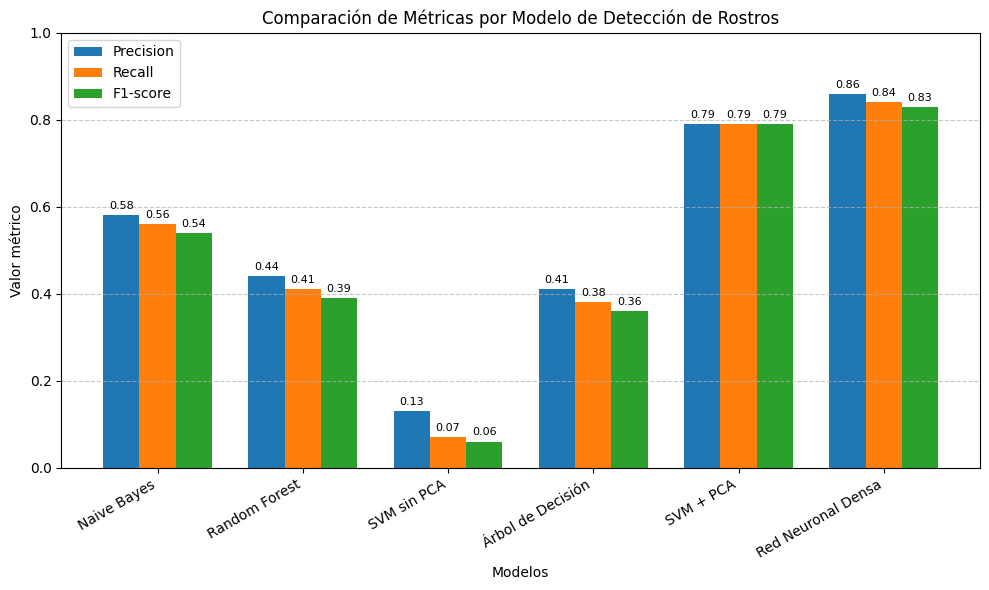

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Nombres de modelos
modelos = ['Naive Bayes', 'Random Forest', 'SVM sin PCA', 'Árbol de Decisión', 'SVM + PCA', 'Red Neuronal Densa']

# Métricas correspondientes
f1_score = [0.54, 0.39, 0.06, 0.36, 0.79, 0.83]
precision = [0.58, 0.44, 0.13, 0.41, 0.79, 0.86]
recall = [0.56, 0.41, 0.07, 0.38, 0.79, 0.84]

x = np.arange(len(modelos))  # posición para las barras

width = 0.25  # ancho de las barras

fig, ax = plt.subplots(figsize=(10,6))

# Barras para cada métrica
bars1 = ax.bar(x - width, precision, width, label='Precision', color='#1f77b4')
bars2 = ax.bar(x, recall, width, label='Recall', color='#ff7f0e')
bars3 = ax.bar(x + width, f1_score, width, label='F1-score', color='#2ca02c')

# Etiquetas y estilo
ax.set_xlabel('Modelos')
ax.set_ylabel('Valor métrico')
ax.set_title('Comparación de Métricas por Modelo de Detección de Rostros')
ax.set_xticks(x)
ax.set_xticklabels(modelos, rotation=30, ha='right')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar valores encima de las barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
